In [1]:
#install.packages('Rcpp')
#install.packages('bnstruct')
#install.packages('bnlearn')

# Caro Garfa ti scrivo

The computationally expensive part of the algorithm is the counting of different instances of variables in the dataset. Given the value $k$ of the variable $i$ of cardinality $r_i$ we are looking at, its (candidate) parents $\pi_i=(\pi_{i1},\dots, \pi_{iM})$ and their cardinality $r_{\pi_{i1}}, \dots, r_{\pi_{iM}}$, we would need to distinguish and count $q_i=\prod_{l=1}^M r_{\pi_{il}}$ possible types of rows in the dataset in order to compute $N_{ijk}$; this would require a relatively trivial mapping from the values of the variables and the configuration index $j=1\dots q_i$ and different _for loops_ which are not "native" in R, i.e. they are executed at runtime, not compiled.

Another problem we occured in is the computation of factorials; for small datasets this is feasible but for bigger ones the factorial of $N_{ijk}$ grows very fast 

In [2]:
library(Rcpp)
library(bnstruct)
library(bnlearn)

Loading required package: bitops
Loading required package: Matrix
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘bnlearn’

The following objects are masked from ‘package:bnstruct’:

    impute, read.bif, read.dsc, read.net, shd, write.dsc

The following objects are masked from ‘package:igraph’:

    compare, degree, path, subgraph

The following object is masked from ‘package:stats’:

    sigma



In [3]:
cmpRes <- sourceCpp('rk2alg.cpp')
cmpRes

$functions
[1] "compute_instance_index" "compute_alpha"          "k2procedure"           
[4] "conditionalProb"       

$modules
character(0)

$cppSourcePath
[1] "/home/vicio/Scrivania/Cpp/rk2alg.cpp"

$buildDirectory
[1] "/tmp/RtmpNBNRAr/sourceCpp-x86_64-pc-linux-gnu-1.0.1/sourcecpp_7136fad4467"

In [4]:
order <- c(0,1,2)  
r <- c(2,2,2)
data <- matrix(c(1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0), 10,3, byrow=T)
mode(data) <- "integer"

In [5]:
res <- k2procedure(data,r,order,u=2,returnType=1)
res

,x0,x1,x2
x0,0,1,0
x1,0,0,1
x2,0,0,0


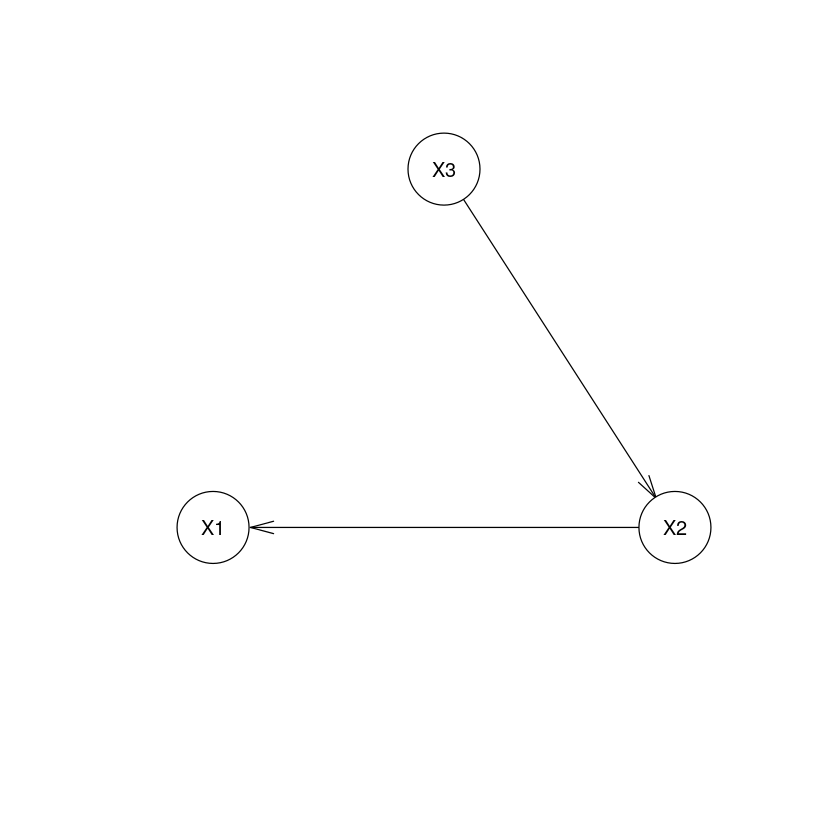

In [6]:
df <- data.frame(data)
df <- data.frame(sapply(df, as.factor))
res <- hc(df, score='k2')
plot(res)

### Bigger dataset

In [17]:
X <- as.matrix(asia)
n <- dim(X)[2]
m <- dim(X)[1]
X[X=='yes']=1
X[X=='no']=0
X<-matrix(as.integer(as.character(X)), m, n)
order <- c(0,1,2,4,5,6,7,3)
r <- rep(2, 8)
X_train <- X[sample(m,100),]
res <- k2procedure(X_train,r,order,4,)

In [27]:
res <- k2procedure(X,r,order, returnType=1, verbose=0,u=4,splitSize=50)
res

,x0,x1,x2,x3,x4,x5,x6,x7
x0,0,0,0,0,1,0,0,0
x1,0,0,0,0,0,1,1,0
x2,0,0,0,0,1,1,1,0
x3,0,0,0,0,0,0,0,0
x4,0,0,0,1,0,1,1,0
x5,0,0,0,1,0,0,0,0
x6,0,0,0,0,0,0,0,0
x7,0,0,0,0,0,0,0,0


In [19]:
conditionalProb(6, X, r, c(1,2,4))

cond. x1,cond. x2,cond. x4,x6,P
0,0,0,0,0.94284065
0,0,0,1,0.05715935
0,0,1,0,0.95212038
0,0,1,1,0.04787962
0,1,0,0,0.00000000
0,1,0,1,1.00000000
0,1,1,0,0.00000000
0,1,1,1,1.00000000
1,0,0,0,0.82930299
1,0,0,1,0.17069701



  Bayesian network learned via Score-based methods

  model:
   [X1][X2][X3][X5|X2:X3][X6|X2:X3][X4|X3:X6][X7|X6][X8|X5:X6] 
  nodes:                                 8 
  arcs:                                  9 
    undirected arcs:                     0 
    directed arcs:                       9 
  average markov blanket size:           2.75 
  average neighbourhood size:            2.25 
  average branching factor:              1.12 

  learning algorithm:                    Hill-Climbing 
  score:                                 Cooper & Herskovits' K2 
  tests used in the learning procedure:  73 
  optimized:                             TRUE 


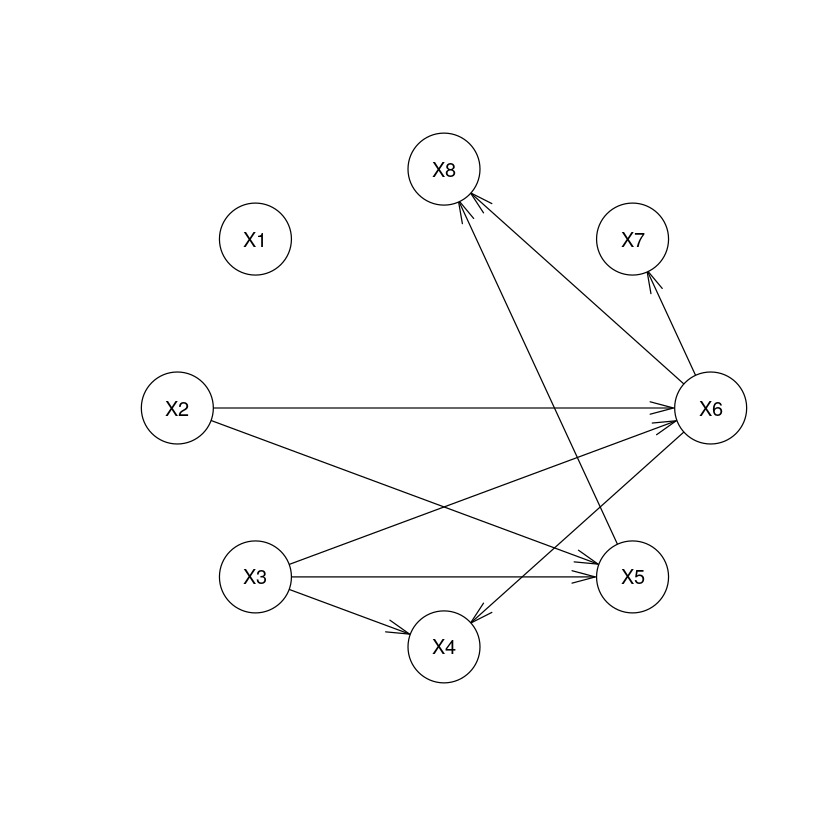

In [21]:
df <- data.frame(X)
df <- data.frame(sapply(df, as.factor))
n <- dim(X)[2]



blistLen <- (n-1)*(n-2)/2
fList <- character(blistLen)
tList <- character(blistLen)
count = 1
for(i in 1:(length(order)-1))
{
    var <- order[i]+1
    for(j in (i+1):length(order))
    {
        jvar <- order[j] + 1
        fList[count] = colnames(df)[jvar]
        tList[count] = colnames(df)[var]
        count = count + 1
    }
}
blist <- cbind(fList,tList)
colnames(blist) <- c('from','to')



res <- hc(df, blacklist=blist, score='k2')
plot(res)
res